# Test notebook, analyzing real data (US wildfires)

In this notebook I analyze a nice dataset I found on Keggle with data on wildfires in the USA.
Can be downloaded here: https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data

In [292]:
import sqlite3
import pandas as pd

# Here I import the essential data I need from the SQLite database
DB_PATH = "FPA_FOD_20170508.sqlite"   # (I put the sqlite in the same folder)


conn = sqlite3.connect(DB_PATH)

query = """
SELECT
    FIRE_SIZE,
    DISCOVERY_DATE,
    CONT_DATE,
    FIRE_YEAR,
    STATE,
    LATITUDE,
    LONGITUDE
FROM Fires
WHERE FIRE_SIZE IS NOT NULL
  AND FIRE_SIZE > 0
  AND DISCOVERY_DATE IS NOT NULL
"""

df = pd.read_sql_query(query, conn) 

conn.close()


In [293]:
df['DURATION_DAYS'] = (df['CONT_DATE'] - df['DISCOVERY_DATE'])

In [294]:
df = df.dropna(subset=["FIRE_SIZE", "DURATION_DAYS","CONT_DATE", "DISCOVERY_DATE"])
df = df[df['DURATION_DAYS'] >= 0]

In [295]:
fire_sizes = df['FIRE_SIZE'].to_numpy()

Text(0.5, 0, 'Fire Size (acres)')

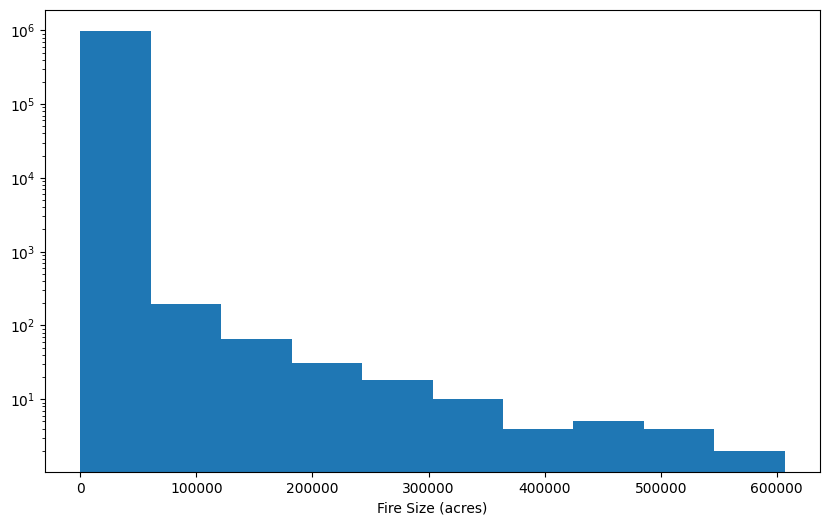

In [296]:
import numpy as np
import matplotlib.pyplot as plt

# Histogram of fire sizes
plt.figure(figsize=(10, 6))
plt.hist(fire_sizes)
plt.yscale('log')
plt.xlabel('Fire Size (acres)')


In [297]:
median_fs = np.median(fire_sizes)
max_fs = np.max(fire_sizes)
mean_fs = np.mean(fire_sizes)
std_fs = np.std(fire_sizes)

print(f"Median fire size: {median_fs}, Max fire size: {max_fs}, Mean fire size: {mean_fs}, Std dev: {std_fs}")

Median fire size: 0.5, Max fire size: 606945.0, Mean fire size: 119.2680979439457, Std dev: 3374.634404885927


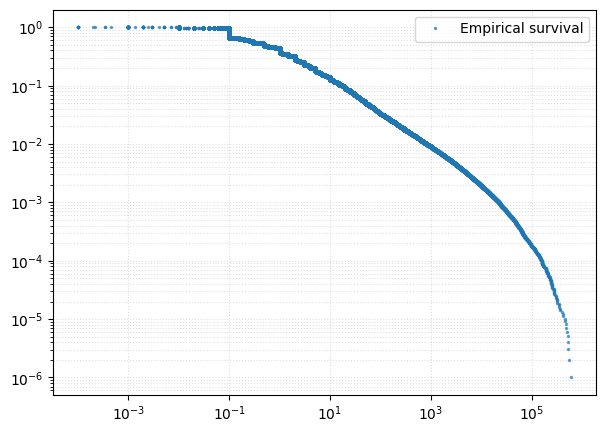

In [298]:
# plot of survival function and power-law fit on loglog plot
x = np.sort(fire_sizes) # sorting the data allows to easily compute empirical survival below!
n = len(x)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n


# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')


plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

Above, the survival function appears to have a power law behavior between 10^0 and 10^5 circa. After, there seems to be a stronger suppression. Let's look at the mean excess plot then

In [299]:
import functions.analysis as fa

Text(0.5, 0, 'Threshold u')

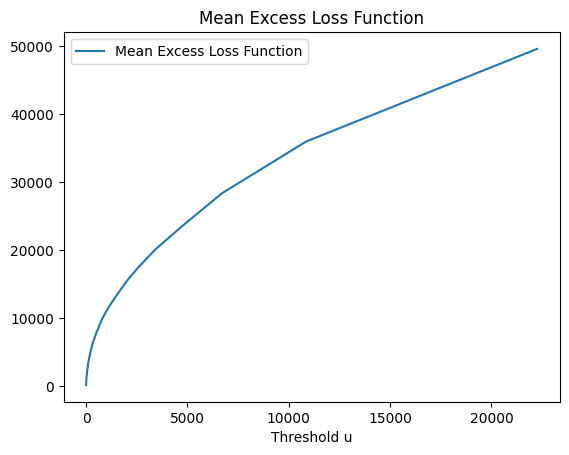

In [300]:
# plot of mean excess loss function
u_values = np.quantile(x, np.linspace(0.20, 0.999, 1000))
mef_values = [fa.mean_excess_loss(fire_sizes, u) for u in u_values]
plt.plot(u_values, mef_values, label='Mean Excess Loss Function')
plt.title('Mean Excess Loss Function')
plt.legend()
plt.xlabel('Threshold u')

Text(0.5, 0, 'Threshold u')

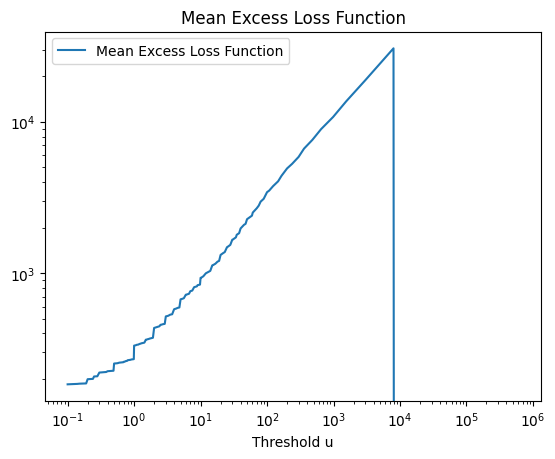

In [301]:
# plot of mean excess loss function
u_values = np.quantile(x, np.logspace(-1, 0, 1000))
mef_values = [fa.mean_excess_loss(fire_sizes, u) for u in u_values]
plt.loglog(u_values, mef_values, label='Mean Excess Loss Function')
plt.title('Mean Excess Loss Function')
plt.legend()
plt.xlabel('Threshold u')

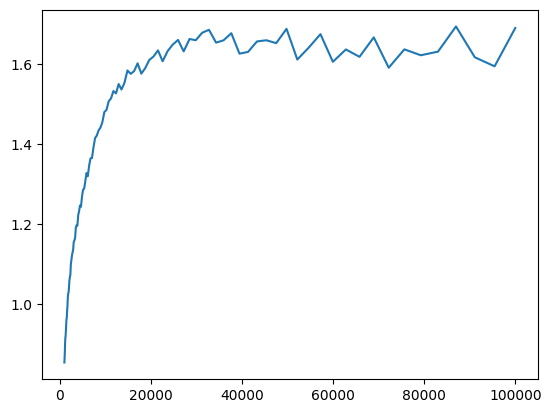

In [302]:
# plot of hill estimator as function of k
k_values = np.logspace(3, 5,100)
hill_values = np.array([fa.hill_estimator(fire_sizes, int(k)) for k in k_values])
plt.plot(k_values, hill_values)
#plt.xlabel('k (number of top order statistics)')
#plt.ylim(0.5, 1.5)

In [303]:
fa.pareto_tail_survival(fire_sizes,p_min=0.80,p_max=0.99)

np.float64(0.5745257851304635)

In [304]:
from scipy.optimize import curve_fit

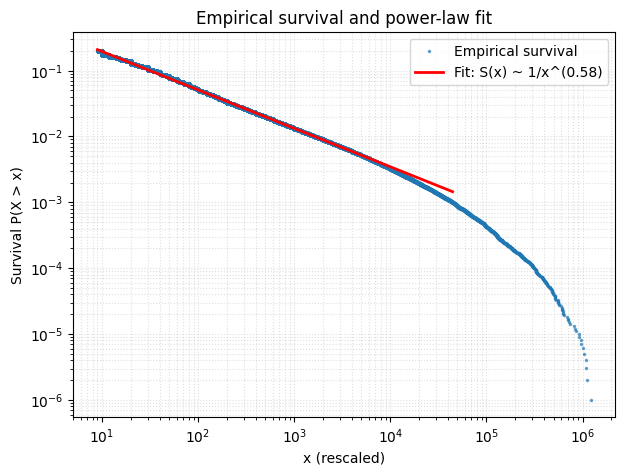

In [305]:
# plot of survival function and power-law fit on loglog plot
res_fs = fire_sizes/np.median(fire_sizes)

x = np.sort(np.asarray(res_fs)) # sorting to compute survival
n = len(x)


surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n

# choose tail threshold
u_min = np.percentile(res_fs, 80)
u_max = np.percentile(res_fs, 99.9)

mask = (x >= u_min) & (x <= u_max)

# fit tail
logx = np.log(x[mask])
logsurv = np.log(surv[mask])
slope, intercept = np.polyfit(logx, logsurv, 1)
alpha_hat = -slope

# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x[x>u_min], surv[x>u_min], marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')

# overlay fitted line
x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
plt.loglog(x_fit, np.exp(intercept) * x_fit**slope, 'r-', lw=2, label=f'Fit: S(x) ~ 1/x^({alpha_hat:.2f})')

plt.xlabel('x (rescaled)')
plt.ylabel('Survival P(X > x)')
plt.title(f'Empirical survival and power-law fit')
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

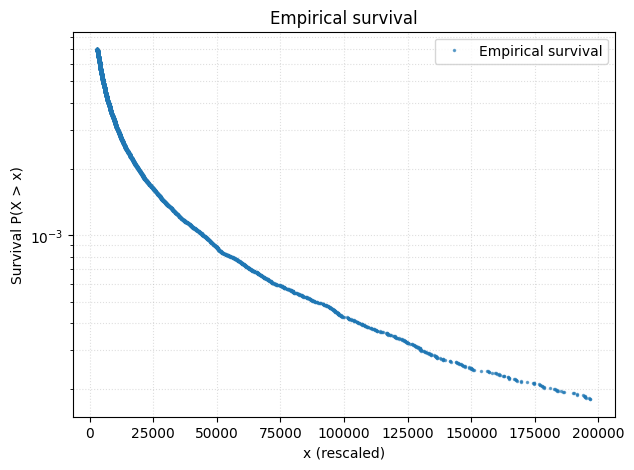

In [306]:

# plot on log-linear
plt.figure(figsize=(7,5))
plt.semilogy(x[(x>3000) & (x<200000)], surv[(x>3000) & (x<200000)], marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')

plt.xlabel('x (rescaled)')
plt.ylabel('Survival P(X > x)')
plt.title(f'Empirical survival')
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

Initial alpha (from Hill, k=9889): 0.6712
Selecting tail in range [0.20, 1213890.00] with 639502 points.


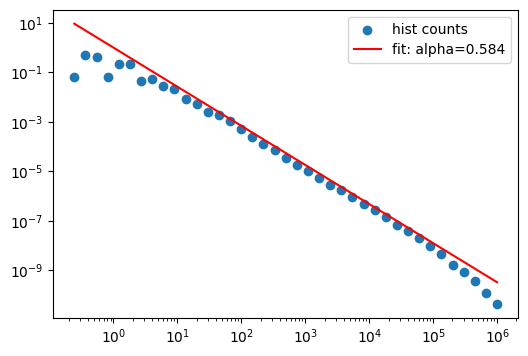

In [307]:


# choose k for hill estimator initial guess
n = len(res_fs)
k0 = int(0.01 * n)
gamma_hat = fa.hill_estimator(res_fs, k0)  # hill gives gamma = 1/alpha
alpha0 = 1.0 / gamma_hat # initial alpha estimate
print(f'Initial alpha (from Hill, k={k0}): {alpha0:.4f}')

# select tail threshold and compute log-spaced histogram
u_min = np.percentile(res_fs, 10)
u_max = np.percentile(res_fs, 100)
tail = res_fs[(res_fs > u_min) & (res_fs < u_max)]

print(f'Selecting tail in range [{u_min:.2f}, {u_max:.2f}] with {len(tail)} points.')

bins = np.logspace(np.log10(u_min), np.log10(u_max), 40)
counts, edges = np.histogram(tail, bins=bins, density=True) # density=True for PDF, otherwise the fit is off (because the bins are not uniform in width)
bin_centers = np.sqrt(edges[:-1] * edges[1:])

# use only bins with positive counts in the tail region
mask = counts > 0
x = bin_centers[mask]
y = counts[mask].astype(float)

def power_law(x, A, alpha):
    return A * x ** (-alpha-1)

alpha_fit = alpha_hat


# plot results
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='hist counts')
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, power_law(xx, 1, alpha_fit),
         color='red', label=f'fit: alpha={alpha_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


(For some reason the direct fitting of the histogram doesn't work well, overflow issue. In any case, if I use the value fitted before, the agreement is pretty spot on!)

Thus, I expect that, when defining severities as a function of (mostly) fire size, I will get heavy-tail distributed severities, hence same distribution for aggregate losses.

One interesting observation is that, at this level, large wildfires are prototypical "black swans", apparently following the same underlying dynamics of smaller fires, just on a different scale (self similarity). There appears to be no "dragon kings" (i.e. extremal events that originate for different exceptional mechanisms, such as phase transitions). Actually, the very fair tail seems to bend downwards with some type of exponential suppression.

In [308]:
df.groupby('STATE').size().sort_values(ascending=False).head(20)

STATE
GA    99240
CA    91908
NY    68949
AZ    66355
OR    60751
MS    42405
MT    36952
SC    34330
AL    31058
ID    30662
OK    30501
CO    28325
NM    28045
UT    26586
NC    26053
FL    21927
WA    21363
SD    20406
MN    19336
WV    17574
dtype: int64

In [309]:
min_num = 1000

state_counts = df.groupby("STATE").size()
test_states = state_counts[state_counts >= min_num].index

# Rank by ratio of max to 99th percentile
def extreme_ratio(x):
    return np.log10(np.max(x) / np.percentile(x,99.9))

# Alternatively, rank by a dynamic range
def dynamic_range(x):
    return np.log10(np.percentile(x, 99.99) / np.percentile(x,50))

# Here I do it with the dynamic range
state_stats = (
    df[df["STATE"].isin(test_states)]
    .groupby("STATE")["FIRE_SIZE"]
    .apply(dynamic_range)
    .sort_values(ascending=False)
)

top_states = state_stats.head(5).index
print("States to analyze:", list(top_states))


States to analyze: ['NV', 'WA', 'CA', 'ID', 'AK']


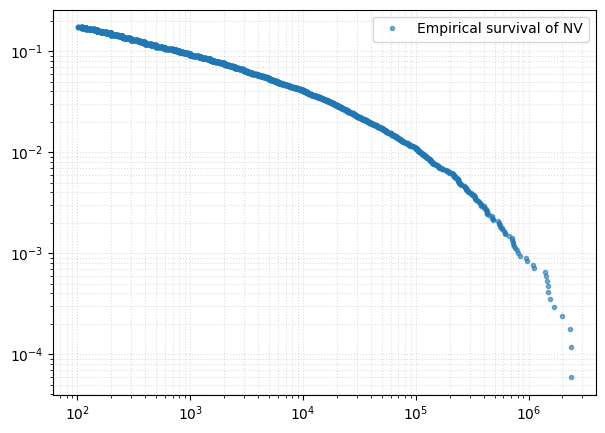

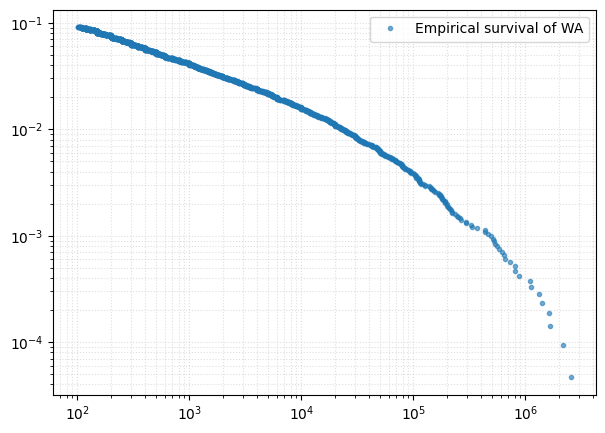

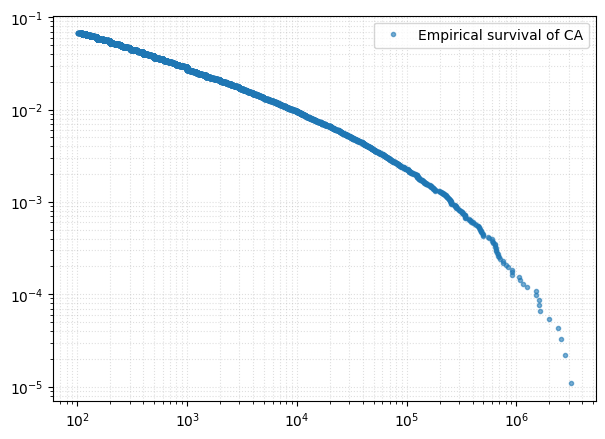

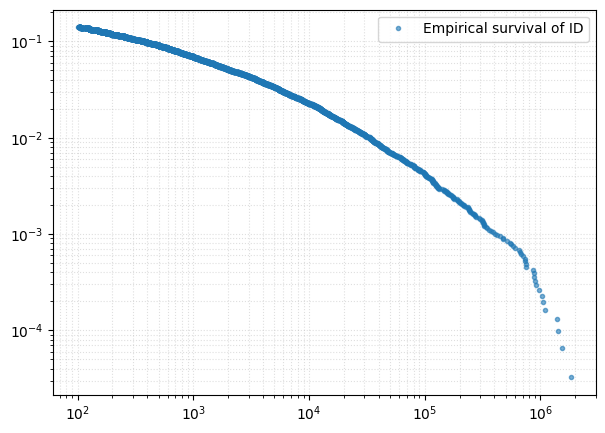

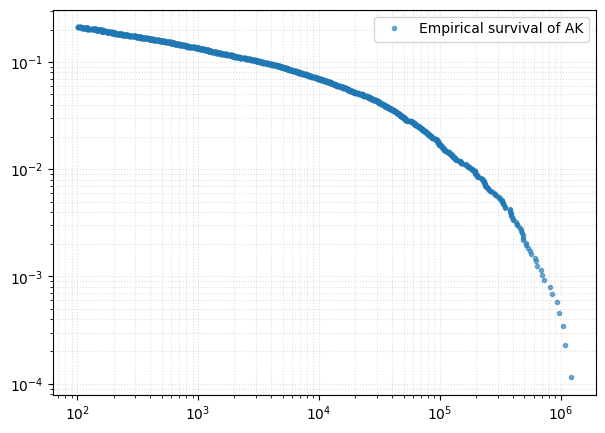

In [310]:
for state in top_states:
    sizes = df.loc[df["STATE"] == state, "FIRE_SIZE"].values

    x = np.sort(sizes)
    n = len(x)

    surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n

    x_res = x / np.median(x)

    # plot on log-log
    plt.figure(figsize=(7,5))
    plt.loglog(x_res[x_res>100], surv[x_res>100], marker='.',linestyle='none', alpha=0.6, label='Empirical survival of ' + state)


    plt.legend()
    plt.grid(which='both', linestyle=':', alpha=0.4)
    plt.show()

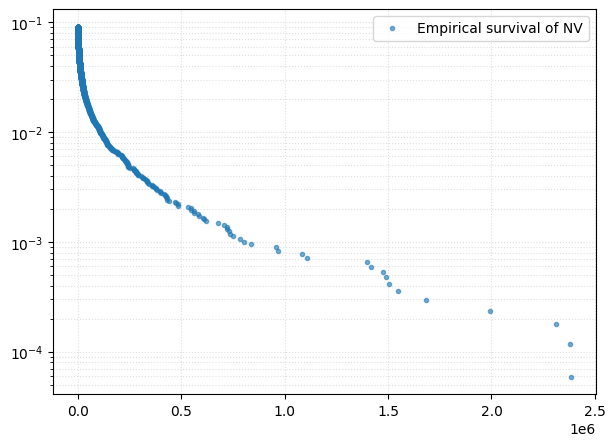

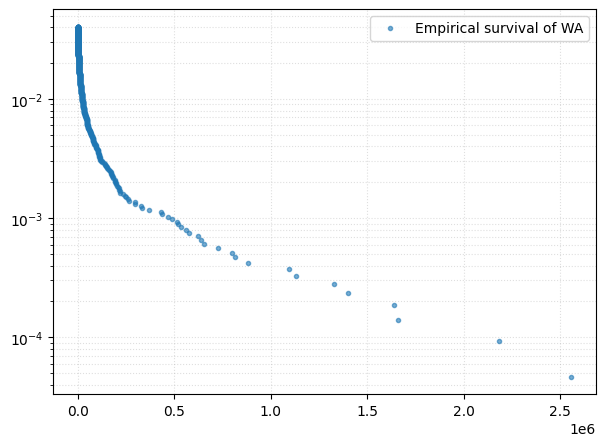

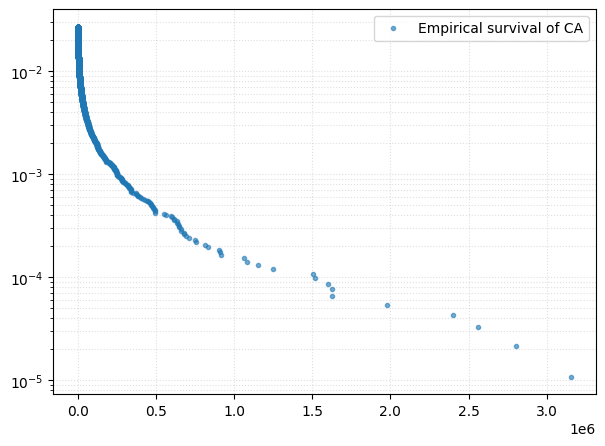

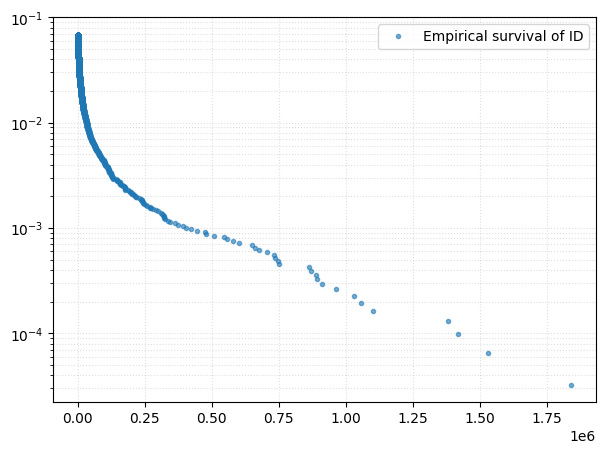

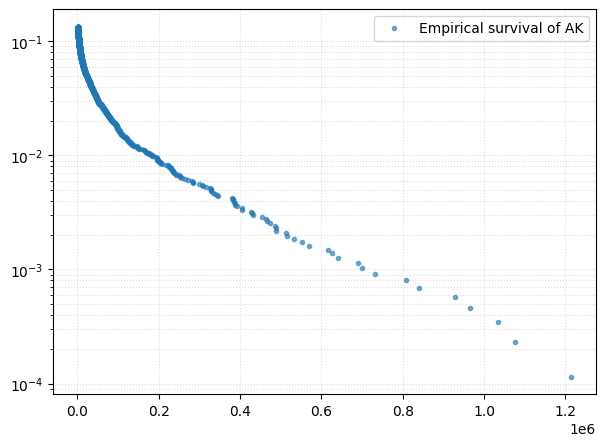

In [311]:
for state in top_states:
    sizes = df.loc[df["STATE"] == state, "FIRE_SIZE"].values

    x = np.sort(sizes)
    n = len(x)

    surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n

    x_res = x / np.median(x)

    # plot on log-linear
    plt.figure(figsize=(7,5))
    plt.semilogy(x_res[x_res>1000], surv[x_res>1000], marker='.',linestyle='none', alpha=0.6, label='Empirical survival of ' + state)


    plt.legend()
    plt.grid(which='both', linestyle=':', alpha=0.4)
    plt.show()

It appears that each state has its own distribution, but certain features remain unaltered: the bulk is pareto distributed, the far tail has an exponential suppression (approximately).

# Test severities 
Let's start by checking what's the dependence between size and duration

In [276]:
# state filter allows to select a specific state.
STATE_FILTER = None

df_sel= df[df["DURATION_DAYS"] > 0].copy()

if STATE_FILTER is not None:
    df_sel = df_sel[df_sel["STATE"] == STATE_FILTER]
else:
    df_sel = df_sel.copy()


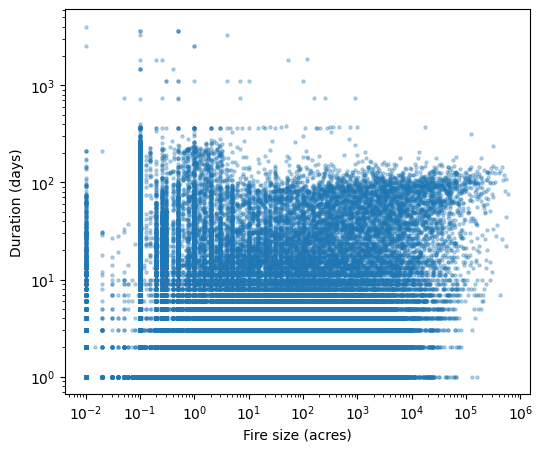

In [277]:
# -----------------------------
# Log-log scatter plot
# -----------------------------
x = df_sel["FIRE_SIZE"].to_numpy()
y = df_sel["DURATION_DAYS"].to_numpy()

plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fire size (acres)")
plt.ylabel("Duration (days)")

plt.show()



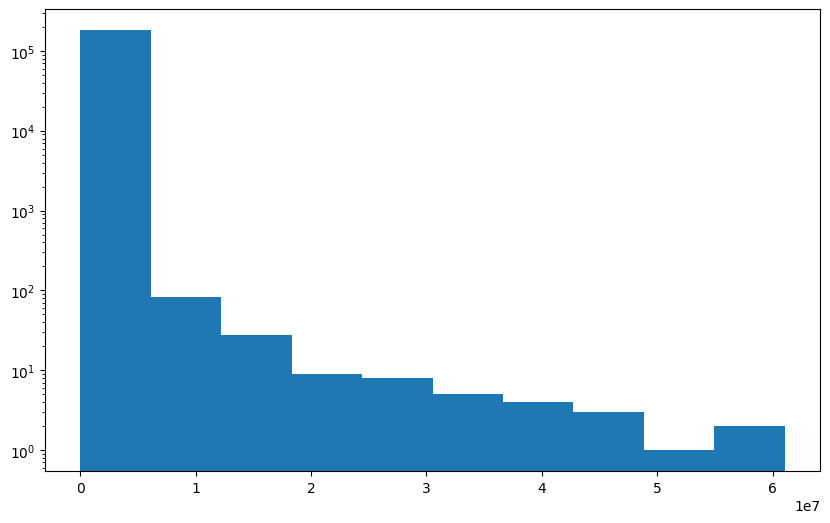

In [280]:
# appears like they are mostly uncorrelated, 
# so I'll use a multiplicative severity
df_sel["SEVERITY"] = df_sel["FIRE_SIZE"] * df_sel["DURATION_DAYS"] 

sevs=df_sel["SEVERITY"].to_numpy()

sevs_res = sevs/np.median(sevs)

plt.figure(figsize=(10, 6))
plt.hist(sevs_res)
plt.yscale('log')

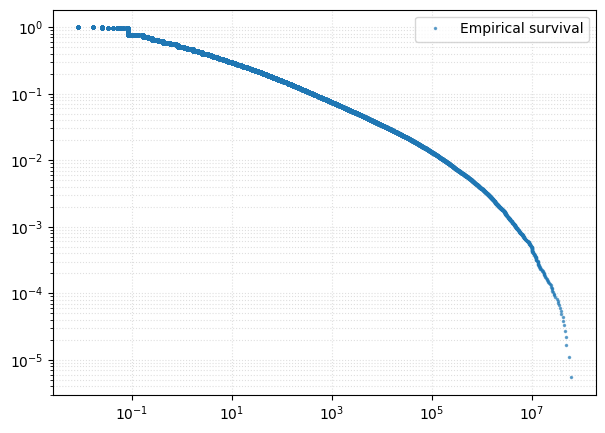

In [284]:
# plot of survival function and power-law fit on loglog plot
x = np.sort(sevs_res)
n = len(x)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n


# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')


plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

In [287]:
p_test=0.99
var_99=fa.calc_var(sevs_res, p_test)
tvar_99=fa.calc_tvar(sevs_res, p_test)

In [288]:
print(var_99, tvar_99)

175772.7666666675 2159333.687955871


In [290]:
#  confidence interval (CI) for the TVaR (default alpha, so 95% CI)

tvar_99, low_tvar, high_tvar, _ = fa.boot_stat(sevs_res, fa.calc_tvar, p=p_test)

In [291]:
print(f"CI (95%) for TVaR of pareto sum: [{low_tvar:.4f}, {high_tvar:.4f}]")

CI (95%) for TVaR of pareto sum: [1921903.8824, 2405385.2326]
